<a href="https://colab.research.google.com/github/bradleylauryn/bradleylauryn.github.io/blob/main/finalproject_citibike_176C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
!pip install geopandas rtree fiona shapely pysal seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import geopandas as gpd
import pysal.lib
from esda.moran import Moran
from libpysal.weights import Queen, KNN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.explore import esda  # Exploratory Spatial analytics
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local
from splot.esda import plot_local_autocorrelation
from splot.esda import plot_moran
from shapely.geometry import Point


/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


# Load and Edit Dataset

**Load the Data**

In [ ]:
file_path = [r'/content/201909-citibike-tripdata.csv']

dfs = []

for file_path in file_path:
  df = pd.read_csv(file_path)
  dfs.append(df)

Bikeshare = pd.concat(dfs, ignore_index=True)

In [ ]:
Bikeshare.shape

(2444900, 15)

In [ ]:
Bikeshare.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,327,2019-09-01 00:00:01.9580,2019-09-01 00:05:29.3410,3733,Avenue C & E 18 St,40.730563,-73.973984,504,1 Ave & E 16 St,40.732219,-73.981656,39213,Subscriber,1968,1
1,1145,2019-09-01 00:00:04.1430,2019-09-01 00:19:09.8360,3329,Degraw St & Smith St,40.682915,-73.993182,270,Adelphi St & Myrtle Ave,40.693083,-73.971789,21257,Customer,1969,0
2,1293,2019-09-01 00:00:07.3090,2019-09-01 00:21:40.7580,3168,Central Park West & W 85 St,40.784727,-73.969617,423,W 54 St & 9 Ave,40.765849,-73.986905,15242,Customer,1969,0
3,1753,2019-09-01 00:00:08.0640,2019-09-01 00:29:21.5040,3299,E 98 St & Park Ave,40.788130,-73.952060,3160,Central Park West & W 76 St,40.778968,-73.973747,38760,Subscriber,1990,1
4,613,2019-09-01 00:00:12.8510,2019-09-01 00:10:26.1850,486,Broadway & W 29 St,40.746201,-73.988557,478,11 Ave & W 41 St,40.760301,-73.998842,32094,Subscriber,1992,1


**2. Get age column**

In [ ]:
Year = 2019
Bikeshare['age'] = Year - Bikeshare['birth year']
Bikeshare

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,age
0,327,2019-09-01 00:00:01.9580,2019-09-01 00:05:29.3410,3733,Avenue C & E 18 St,40.730563,-73.973984,504,1 Ave & E 16 St,40.732219,-73.981656,39213,Subscriber,1968,1,51
1,1145,2019-09-01 00:00:04.1430,2019-09-01 00:19:09.8360,3329,Degraw St & Smith St,40.682915,-73.993182,270,Adelphi St & Myrtle Ave,40.693083,-73.971789,21257,Customer,1969,0,50
2,1293,2019-09-01 00:00:07.3090,2019-09-01 00:21:40.7580,3168,Central Park West & W 85 St,40.784727,-73.969617,423,W 54 St & 9 Ave,40.765849,-73.986905,15242,Customer,1969,0,50
3,1753,2019-09-01 00:00:08.0640,2019-09-01 00:29:21.5040,3299,E 98 St & Park Ave,40.788130,-73.952060,3160,Central Park West & W 76 St,40.778968,-73.973747,38760,Subscriber,1990,1,29
4,613,2019-09-01 00:00:12.8510,2019-09-01 00:10:26.1850,486,Broadway & W 29 St,40.746201,-73.988557,478,11 Ave & W 41 St,40.760301,-73.998842,32094,Subscriber,1992,1,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444895,1764,2019-09-30 23:59:22.7670,2019-10-01 00:28:47.3180,3314,W 95 St & Broadway,40.793770,-73.971888,3161,W 76 St & Columbus Ave,40.780184,-73.977285,41516,Customer,1995,1,24
2444896,378,2019-09-30 23:59:27.9270,2019-10-01 00:05:46.5700,316,Fulton St & William St,40.709560,-74.006536,327,Vesey Pl & River Terrace,40.715338,-74.016584,31124,Subscriber,1959,2,60
2444897,561,2019-09-30 23:59:29.1450,2019-10-01 00:08:50.8070,3260,Mercer St & Bleecker St,40.727064,-73.996621,393,E 5 St & Avenue C,40.722992,-73.979955,30285,Customer,1998,1,21
2444898,311,2019-09-30 23:59:42.2520,2019-10-01 00:04:54.2320,3746,6 Ave & Broome St,40.724308,-74.004730,3435,Grand St & Elizabeth St,40.718822,-73.995960,38290,Subscriber,1989,1,30


**3. Drop round trips**

In [ ]:
Bike_one_way = Bikeshare[(Bikeshare['start station name'] != Bikeshare['end station name'])].copy()

In [ ]:
Bike_one_way.shape

(2390193, 16)

**4. Drop irrelevant columns**

In [ ]:
columns_to_drop = ['gender', 'bikeid', 'usertype']
Bike_true = Bike_one_way.drop(columns_to_drop, axis=1)

**5. Drop rows with empty values**

In [ ]:
Bike_true = Bike_true.dropna()
Bike_true

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,birth year,age
0,327,2019-09-01 00:00:01.9580,2019-09-01 00:05:29.3410,3733,Avenue C & E 18 St,40.730563,-73.973984,504,1 Ave & E 16 St,40.732219,-73.981656,1968,51
1,1145,2019-09-01 00:00:04.1430,2019-09-01 00:19:09.8360,3329,Degraw St & Smith St,40.682915,-73.993182,270,Adelphi St & Myrtle Ave,40.693083,-73.971789,1969,50
2,1293,2019-09-01 00:00:07.3090,2019-09-01 00:21:40.7580,3168,Central Park West & W 85 St,40.784727,-73.969617,423,W 54 St & 9 Ave,40.765849,-73.986905,1969,50
3,1753,2019-09-01 00:00:08.0640,2019-09-01 00:29:21.5040,3299,E 98 St & Park Ave,40.788130,-73.952060,3160,Central Park West & W 76 St,40.778968,-73.973747,1990,29
4,613,2019-09-01 00:00:12.8510,2019-09-01 00:10:26.1850,486,Broadway & W 29 St,40.746201,-73.988557,478,11 Ave & W 41 St,40.760301,-73.998842,1992,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444895,1764,2019-09-30 23:59:22.7670,2019-10-01 00:28:47.3180,3314,W 95 St & Broadway,40.793770,-73.971888,3161,W 76 St & Columbus Ave,40.780184,-73.977285,1995,24
2444896,378,2019-09-30 23:59:27.9270,2019-10-01 00:05:46.5700,316,Fulton St & William St,40.709560,-74.006536,327,Vesey Pl & River Terrace,40.715338,-74.016584,1959,60
2444897,561,2019-09-30 23:59:29.1450,2019-10-01 00:08:50.8070,3260,Mercer St & Bleecker St,40.727064,-73.996621,393,E 5 St & Avenue C,40.722992,-73.979955,1998,21
2444898,311,2019-09-30 23:59:42.2520,2019-10-01 00:04:54.2320,3746,6 Ave & Broome St,40.724308,-74.004730,3435,Grand St & Elizabeth St,40.718822,-73.995960,1989,30


**5. Identify and Remove Outliers**

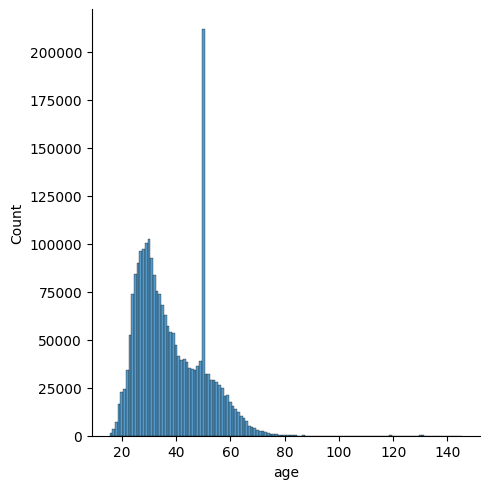

In [ ]:
sns.displot(Bike_true, x="age", discrete = True)

In [ ]:
Bike_true = Bike_true.loc[(Bike_true['age'] <= 80)]
Bike_true.shape

(2387542, 13)

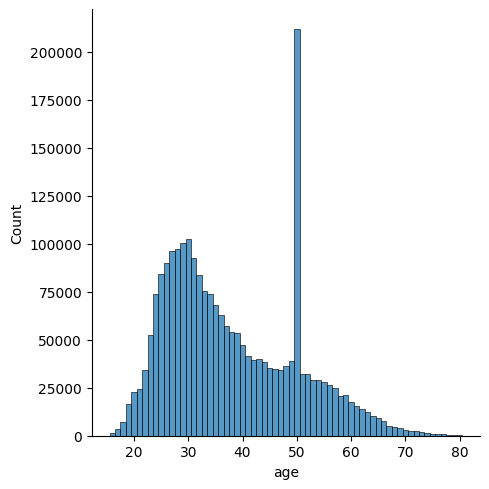

In [ ]:
sns.displot(Bike_true, x="age", discrete = True)

In [ ]:
Bike_true = Bike_true.loc[(Bike_true['age'] != 50)]
Bike_true.shape

(2175856, 13)

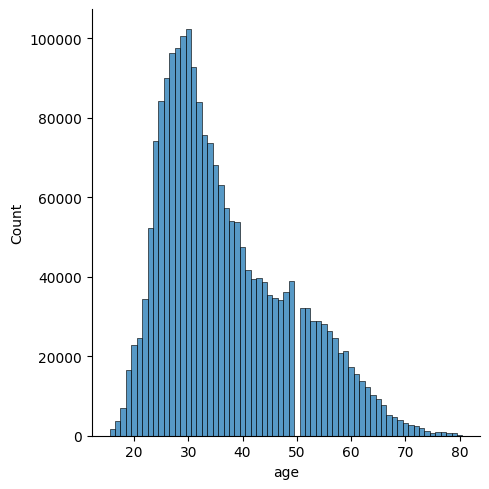

In [ ]:
sns.displot(Bike_true, x="age", discrete = True)

In [ ]:
Bike_true.loc[Bike_true['age'] <= 24, 'age_groups'] = 'Young'

Bike_true.loc[(Bike_true['age'] > 24) & (Bike_true['age'] < 50), 'age_groups'] = 'Middle Age'

Bike_true.loc[Bike_true['age'] >= 50, 'age_groups'] = 'Senior'

Bike_true.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,birth year,age,age_groups
0,327,2019-09-01 00:00:01.9580,2019-09-01 00:05:29.3410,3733,Avenue C & E 18 St,40.730563,-73.973984,504,1 Ave & E 16 St,40.732219,-73.981656,1968,51,Senior
3,1753,2019-09-01 00:00:08.0640,2019-09-01 00:29:21.5040,3299,E 98 St & Park Ave,40.788130,-73.952060,3160,Central Park West & W 76 St,40.778968,-73.973747,1990,29,Middle Age
4,613,2019-09-01 00:00:12.8510,2019-09-01 00:10:26.1850,486,Broadway & W 29 St,40.746201,-73.988557,478,11 Ave & W 41 St,40.760301,-73.998842,1992,27,Middle Age
8,571,2019-09-01 00:00:20.1620,2019-09-01 00:09:51.2430,440,E 45 St & 3 Ave,40.752554,-73.972826,505,6 Ave & W 33 St,40.749013,-73.988484,1995,24,Young
10,2000,2019-09-01 00:00:28.5160,2019-09-01 00:33:49.4820,3295,Central Park W & W 96 St,40.791270,-73.964839,492,W 33 St & 7 Ave,40.750200,-73.990931,1996,23,Young


**6. Identify and Remove Outliers -- Tripduration**

<Axes: xlabel='tripduration', ylabel='age_groups'>

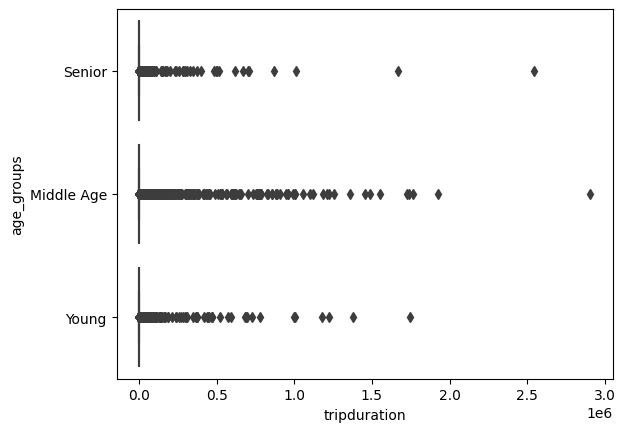

In [ ]:
sns.boxplot(x = Bike_true["tripduration"], y = Bike_true["age_groups"])

In [ ]:
def duration_outliers(group):
    Q1 = group['tripduration'].quantile(0.25)
    Q3 = group['tripduration'].quantile(0.75)
    IQR = Q3 - Q1

    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR

    return group[(group['tripduration'] > lower) & (group['tripduration'] < upper)]

Bike_trip = Bike_true.groupby('age_groups').apply(duration_outliers)

(len(Bike_true), len(Bike_trip))

(2175856, 2085735)

<Axes: xlabel='tripduration', ylabel='age_groups'>

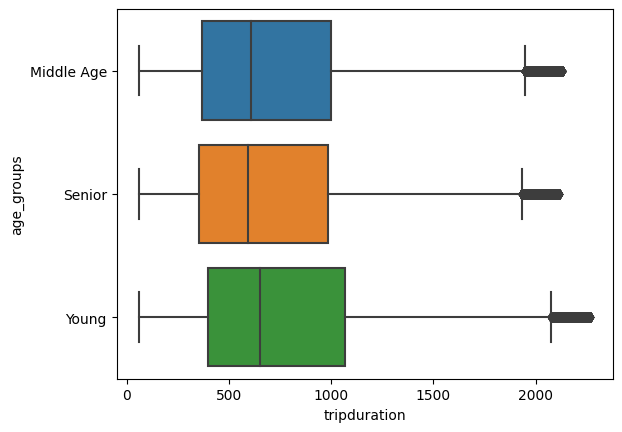

In [ ]:
sns.boxplot(x = Bike_trip["tripduration"], y = Bike_trip["age_groups"])

<Axes: xlabel='tripduration', ylabel='age_groups'>

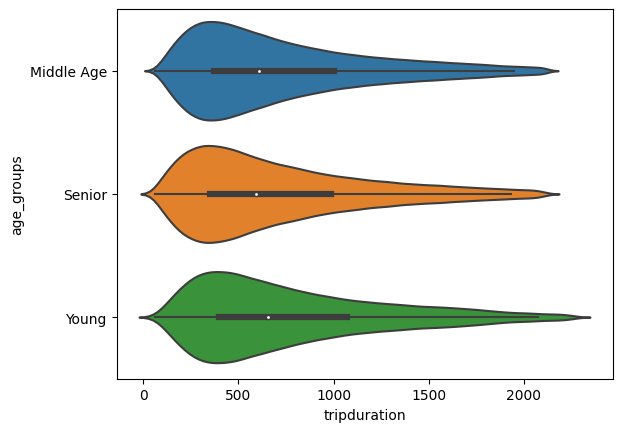

In [ ]:
sns.violinplot(x = Bike_trip["tripduration"], y = Bike_trip["age_groups"])

**6. Identify and Remove Outliers -- Geographic**

Remove those points that lies in Jersy City

In [ ]:
Bike_geo = Bike_trip

Bike_geo = gpd.GeoDataFrame(data=Bike_geo, geometry=gpd.points_from_xy(Bike_trip['start station longitude'], Bike_trip['start station latitude']), crs=4326)
Bike_geo = Bike_geo.rename_geometry("start_geom")

Bike_geo['end_geom'] = gpd.points_from_xy(Bike_trip['end station longitude'], Bike_trip['end station latitude'], crs=4326)

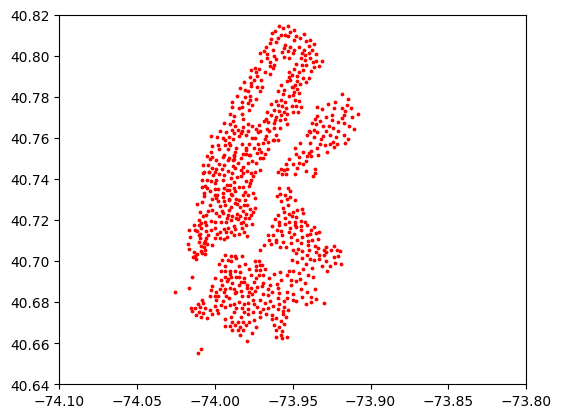

In [ ]:
unique_start = Bike_geo['start_geom'].unique()
start_gdf = gpd.GeoDataFrame(geometry=unique_start)

start_gdf.plot(marker='o', color='red', markersize=3)

plt.ylim(40.64, 40.82)
plt.xlim(-74.1, -73.8)

plt.show()

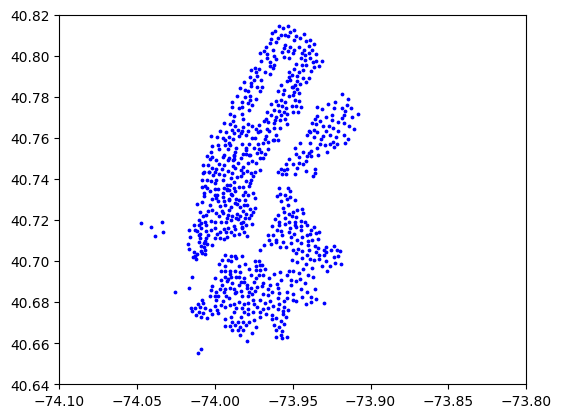

In [ ]:
unique_end = Bike_geo['end_geom'].unique()
end_gdf = gpd.GeoDataFrame(geometry=unique_end)

end_gdf.plot(marker='o', color='blue', markersize=3)

plt.ylim(40.64, 40.82)
plt.xlim(-74.1, -73.8)

plt.show()

In [ ]:
geo_outliers = Bike_geo.loc[Bike_geo['end station longitude'] < -74.02].loc[Bike_geo['end station latitude'] > 40.7]
geo_outliers_geom = geo_outliers['end_geom']

len(geo_outliers_geom)

5

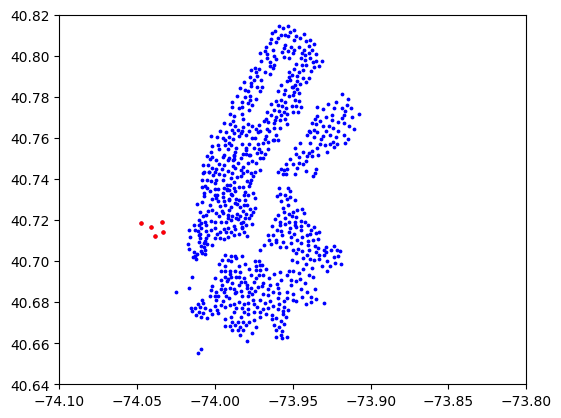

In [ ]:
fig, ax = plt.subplots()

end_gdf.plot(ax = ax, marker='o', color='blue', markersize=3, zorder = 0)
geo_outliers_geom.plot(ax = ax, marker='o', color='red', markersize=5, zorder = 1)

plt.ylim(40.64, 40.82)
plt.xlim(-74.1, -73.8)

plt.show()

In [ ]:
Bike_geo_removed = Bike_trip.loc[~Bike_trip['end station id'].isin(geo_outliers['end station id'])]

(len(Bike_geo_removed), len(Bike_geo))

(2085730, 2085735)

**7. Export csv files for age group**

In [ ]:
Young = Bike_geo_removed.loc[(Bike_geo_removed['age_groups'] == 'Young')].reset_index(drop = True)
Middle_age = Bike_geo_removed.loc[(Bike_geo_removed['age_groups'] == 'Middle Age')].reset_index(drop = True)
Senior = Bike_geo_removed.loc[(Bike_geo_removed['age_groups'] == 'Senior')].reset_index(drop = True)

In [ ]:
Young.to_csv('/content/Young.csv')
Middle_age.to_csv('/content/Middle_age.csv')
Senior.to_csv('/content/Senior.csv')
Bike_geo_removed.to_csv('/content/All_ages.csv')

In [ ]:
Bike_true = Bike_geo_removed

**8. Import New datasets and create dataframe**

In [ ]:
file_path1 = [r'/content/Middle_age.csv']

dfs = []

for file_path1 in file_path1:
    df = pd.read_csv(file_path1)
    dfs.append(df)

Middle_age = pd.concat(dfs, ignore_index=True)

In [ ]:
Middle_age.head()

,Unnamed: 0,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,birth year,age,age_groups
0,0,1753,2019-09-01 00:00:08.0640,2019-09-01 00:29:21.5040,3299,E 98 St & Park Ave,40.788130,-73.952060,3160,Central Park West & W 76 St,40.778968,-73.973747,1990,29,Middle Age
1,1,613,2019-09-01 00:00:12.8510,2019-09-01 00:10:26.1850,486,Broadway & W 29 St,40.746201,-73.988557,478,11 Ave & W 41 St,40.760301,-73.998842,1992,27,Middle Age
2,2,831,2019-09-01 00:00:32.4180,2019-09-01 00:14:24.3550,435,W 21 St & 6 Ave,40.741740,-73.994156,173,Broadway & W 49 St,40.760683,-73.984527,1986,33,Middle Age
3,3,168,2019-09-01 00:00:33.0870,2019-09-01 00:03:21.5970,3526,31 St & 23 Ave,40.774788,-73.912555,3517,31 St & Hoyt Ave N,40.771153,-73.917007,1985,34,Middle Age
4,4,176,2019-09-01 00:00:33.4550,2019-09-01 00:03:30.3780,3095,Graham Ave & Herbert St,40.719293,-73.945004,3668,Leonard St & Nassau Ave,40.723957,-73.949844,1991,28,Middle Age


In [ ]:
Middle_age.shape

(1514594, 15)

In [ ]:
middle_gdf = gpd.GeoDataFrame(data=Middle_age, geometry=gpd.points_from_xy(Middle_age['start station longitude'], Middle_age['start station latitude']))


In [ ]:
middle_gdf = gpd.GeoDataFrame(data=Middle_age, geometry=gpd.points_from_xy(Middle_age['end station longitude'], Middle_age['end station latitude']))
middle_gdf.head()


,Unnamed: 0,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,birth year,age,age_groups,geometry
0,0,1753,2019-09-01 00:00:08.0640,2019-09-01 00:29:21.5040,3299,E 98 St & Park Ave,40.788130,-73.952060,3160,Central Park West & W 76 St,40.778968,-73.973747,1990,29,Middle Age,POINT (-73.97375 40.77897)
1,1,613,2019-09-01 00:00:12.8510,2019-09-01 00:10:26.1850,486,Broadway & W 29 St,40.746201,-73.988557,478,11 Ave & W 41 St,40.760301,-73.998842,1992,27,Middle Age,POINT (-73.99884 40.76030)
2,2,831,2019-09-01 00:00:32.4180,2019-09-01 00:14:24.3550,435,W 21 St & 6 Ave,40.741740,-73.994156,173,Broadway & W 49 St,40.760683,-73.984527,1986,33,Middle Age,POINT (-73.98453 40.76068)
3,3,168,2019-09-01 00:00:33.0870,2019-09-01 00:03:21.5970,3526,31 St & 23 Ave,40.774788,-73.912555,3517,31 St & Hoyt Ave N,40.771153,-73.917007,1985,34,Middle Age,POINT (-73.91701 40.77115)
4,4,176,2019-09-01 00:00:33.4550,2019-09-01 00:03:30.3780,3095,Graham Ave & Herbert St,40.719293,-73.945004,3668,Leonard St & Nassau Ave,40.723957,-73.949844,1991,28,Middle Age,POINT (-73.94984 40.72396)


In [ ]:
Bike_true['starttime'] = pd.to_datetime(Bike_true['starttime'])
Bike_true['stoptime'] = pd.to_datetime(Bike_true['stoptime'])
Bike_true.head()

<ipython-input-40-e6632b95462e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bike_true['starttime'] = pd.to_datetime(Bike_true['starttime'])
<ipython-input-40-e6632b95462e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bike_true['stoptime'] = pd.to_datetime(Bike_true['stoptime'])


tripduration               starttime                stoptime  \
age_groups                                                                    
Middle Age 3           1753 2019-09-01 00:00:08.064 2019-09-01 00:29:21.504   
           4            613 2019-09-01 00:00:12.851 2019-09-01 00:10:26.185   
           11           831 2019-09-01 00:00:32.418 2019-09-01 00:14:24.355   
           12           168 2019-09-01 00:00:33.087 2019-09-01 00:03:21.597   
           13           176 2019-09-01 00:00:33.455 2019-09-01 00:03:30.378   

               start station id       start station name  \
age_groups                                                 
Middle Age 3               3299       E 98 St & Park Ave   
           4                486       Broadway & W 29 St   
           11               435          W 21 St & 6 Ave   
           12              3526           31 St & 23 Ave   
           13              3095  Graham Ave & Herbert St   

               start station latitude  start station longitude  \
age_groups                                                       
Middle Age 3                40.788130               -73.952060   
           4                40.746201               -73.988557   
           11               40.741740               -73.994156   
           12               40.774788               -73.912555   
           13               40.719293               -73.945004   

               end station id             end station name  \
age_groups                                                   
Middle Age 3             3160  Central Park West & W 76 St   
           4              478             11 Ave & W 41 St   
           11             173           Broadway & W 49 St   
           12            3517           31 St & Hoyt Ave N   
           13            3668      Leonard St & Nassau Ave   

               end station latitude  end station longitude  birth year  age  \
age_groups                                                                    
Middle Age 3              40.778968             -73.973747        1990   29   
           4              40.760301             -73.998842        1992   27   
           11             40.760683             -73.984527        1986   33   
           12             40.771153             -73.917007        1985   34   
           13             40.723957             -73.949844        1991   28   

               age_groups  
age_groups                 
Middle Age 3   Middle Age  
           4   Middle Age  
           11  Middle Age  
           12  Middle Age  
           13  Middle Age

In [ ]:
#
print(f'Time span: {Bike_true["starttime"].min()} - {Bike_true["stoptime"].max()}')

Time span: 2019-09-01 00:00:01.958000 - 2019-10-01 00:28:47.318000


# Visualization

<Axes: >

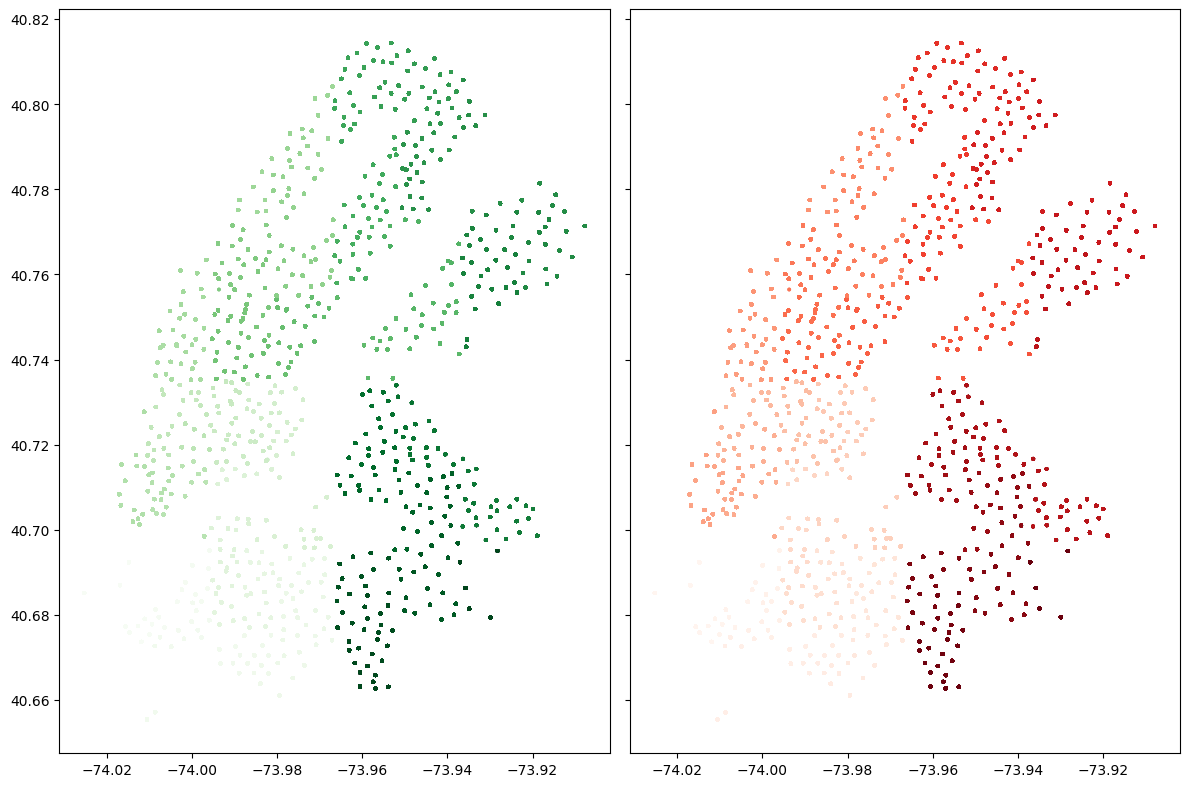

In [ ]:
fig3, ax3 = plt.subplots(1,2, sharey=True, tight_layout = True, figsize = (12,8))
middle_gdf.plot(column = middle_gdf['geometry'], cmap = 'Greens', ax=ax3[0], markersize = 3)
middle_gdf.plot(column = middle_gdf['geometry'], cmap = 'Reds', ax=ax3[1], markersize = 3)

In [ ]:
Middle_Diff_Start = middle_gdf[~middle_gdf.geometry.isin(middle_gdf)]
Middle_Diff_End = middle_gdf[~middle_gdf.geometry.isin(middle_gdf)]


In [ ]:
middle_gdf.to_csv('Middle_gdf.csv')

In [ ]:
p_geometry = [Point(xy) for xy in zip(middle_gdf['start station longitude'], middle_gdf['start station latitude'])]
p_gdf = gpd.GeoDataFrame(middle_gdf, geometry=p_geometry)

# Set the coordinate reference system (CRS) if known
p_gdf.crs = 'EPSG:4326'  # Example: WGS84

In [ ]:
output_shp = 'p_middle.shp'
p_gdf.to_file(output_shp, driver='ESRI Shapefile')

<ipython-input-47-d788d415e239>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  p_gdf.to_file(output_shp, driver='ESRI Shapefile')


In [ ]:
data = gpd.read_file('/content/p_middle.shp')

In [ ]:
# Generate a k-nearest neighbor weights matrix
k = 5  # Number of nearest neighbors
weights = KNN.from_dataframe(data, k=k)

/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 804 disconnected components.
  warnings.warn(message)


In [ ]:
lisa = esda.Moran_Local(data['tripdurati'], weights)

In [ ]:
# Set figure size
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')

# Import NYC Neighborhood Shape Files
nyc_full = gpd.read_file('/content/nyc.shx')
nyc_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', label=nyc_full['geometry'], zorder=1)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
gpd.plotting.plot_dataframe(data, ax=ax, facecolor='gray')  # Plot the base map

# Plot LISA clusters using different colors
lisa_cluster_colors = ['red', 'blue', 'orange', 'yellow', 'green']
legend_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']  # Labels for the legend

for i, cluster in enumerate(lisa.q):
    if cluster > 0:
        color = lisa_cluster_colors[cluster]
        ax.plot(data.geometry[i].x, data.geometry[i].y, 'o', color=color, markersize=5)

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
                   for label, color in zip(legend_labels, lisa_cluster_colors)]
ax.legend(handles=legend_elements, loc='lower right')

plt.show()

In [ ]:
data.head()

In [ ]:
sns.pointplot(x = 'tripdurati', y = 'start stat', data = data)
sns.despine()

In [ ]:
middle_gdf.head()

In [ ]:

#calculate frequency of trip duration

duration_counts = middle_gdf['tripduration'].value_counts()

# Print frequency
print(duration_counts)


**LISA Clustering for Frequency**

In [ ]:
ssd = []
for i in range(2, 26):
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(df_pickup_filtered)
    ssd.append(km.inertia_)

In [ ]:
demand_by_station = daily_data.pivot_table(
    index='start_station_name', columns='month', values='n_bikes', aggfunc='sum')
ax = sns.heatmap(demand_by_station, center=0, annot=False, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Demand by Station')
plt.show()

In [ ]:

# Load bike share station data into a GeoDataFrame
bike_stations = gpd.read_file('/content/YoungFrequencyTable.csv')  # Replace 'bike_stations.shp' with the path to your shapefile

# Create spatial weights matrix (Queen's contiguity)
w = lib.weights.Queen.from_dataframe(bike_stations)

# Compute LISA statistics (Local Moran's I)
lisa = esda.Moran_Local(bike_stations['FREQUENCY'], w)

# Generate LISA cluster map
bike_stations['LISA_cluster'] = lisa.q
bike_stations.plot(column='LISA_cluster', cmap='coolwarm', legend=True)

In [ ]:
!pip transbigdata